## Objetivo

Os objetivos desta lista de exercícios são:
 - proporcionar uma vivência prática de processamento de diferentes “sinais” multimídia (áudio e imagens).
 - compreender as características básicas destes sinais;
 - explorar como as emoções podem ser analisadas a partir da modelagem destas características (features);
 - entrar em contato com algumas ferramentas software existentes.


## Atividades selecionadas

###  Atividade 5 (5,0 pontos)
 - Faça o download do corpus disponibilizado no link (link não pode ser compartilhado).
 - Esse corpus contém imagens da face de uma atriz expressando quatro estados emocionais diferentes, além do estado neutro: “joy”, “anger”, “fear”, “sadness”. O arquivo “imagedb_CH_disciplina.csv” associa cada imagem a um rótulo emocional e também a coordenadas de pontos característicos da face. Atenção, este corpus não deve ser compartilhado por estar sujeito a cessão de direitos de uso de voz e imagens especiais. Ao realizar o download do corpus você estará se comprometendo a respeitar os princípios de não-compartilhamento dos dados e de uso exclusivo para fins específicos de estudo e pesquisa no contexto desta disciplina.
 - Implemente um classificador de emoções para esta base, baseado nos pontos característicos da face (“features” geométricos ou de “shape”).
 - Apresente um relatório detalhado desta atividade, esclarecendo a abordagem adotada e os resultados obtidos. Analise e critique os resultados.

### Atividade 6 (5,0 pontos)
 - Acesse o tutorial [Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV](http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-land)
 - Execute o tutorial.
 - Crie um relatório do cumprimento da atividade, incluindo imagens e trechos do código desenvolvidos. Relate os principais problemas encontrados e as lições aprendidas. Analise e discuta seus resultados.


## Exercício Resolvido - Atividade 6

Neste notebook será implementado e resolvido a ATIVIDADE 6.

### Instalação OpenCV e DLib

- [opencv-python](https://pypi.org/project/opencv-python/)
- [dlib](https://pypi.org/project/dlib/)
- [dlib - shape_predictor_68_face_landmarks.dat](http://dlib.net/face_landmark_detection.py.html)

In [1]:
# !apt-get install build-essential cmake pkg-config libx11-dev libatlas-base-dev libgtk-3-dev libboost-python-dev
# !pip install dlib
# !pip install opencv-python opencv-contrib-python

### Import das bibliotecas a serem utilizadas

In [41]:
import math
import os
import glob
from random import choices, shuffle
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import SVC
import dlib
import cv2

%matplotlib inline

pp = pprint.PrettyPrinter(indent=4)

### Carregamento dos classificadores

Para a tarefa em questão, também será carregado o *HaarCascade Classifier* da *OpenCV* para a identificação de faces e o face detector e shape landmark da *DLib* que retornará o posicionamento dos principais landmarks de uma face.

<img src="images/landmarks.png" width="200" />

In [3]:
face_cascades = [
    cv2.CascadeClassifier('classifier/haarcascade_frontalface_default.xml'),
    cv2.CascadeClassifier('classifier/haarcascade_frontalface_alt.xml'),
    cv2.CascadeClassifier('classifier/haarcascade_frontalface_alt2.xml'),
    cv2.CascadeClassifier('classifier/haarcascade_frontalface_alt_tree.xml'),
]

# Face detector
detector = dlib.get_frontal_face_detector()
# Landmark identifier. Set the filename to whatever you named the downloaded file
predictor = dlib.shape_predictor('classifier/shape_predictor_68_face_landmarks.dat')

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

sentiments = ['neutral', 'anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

### Carregamento de imagens (com emoções) para avaliar os classificadores

Vamos realizar o carregamento de algumas imagens de pessoas demonstrando sentimentos, para que possamos realizar pequenos testes.

Essa imagens, estão a parte do nosso conjunto de imagens para treinamento e validação preliminar, elas serão usadas para validar o classificador, após seu treino.

In [4]:
frames = (
    (cv2.imread('faces/angry-face.jpg'), 'Angry'),
    (cv2.imread('faces/angry-face2.jpg'), 'Angry'),
    (cv2.imread('faces/disgusting-face.jpeg'), 'Disgust'),
    (cv2.imread('faces/disgusting-face2.jpeg'), 'Disgust'),
    (cv2.imread('faces/happy-face.jpg'), 'Happy'),
    (cv2.imread('faces/happy-face2.jpg'), 'Happy'),
    (cv2.imread('faces/sad-face.jpeg'), 'Sad'),
    (cv2.imread('faces/sad-face2.jpeg'), 'Sad'),
    (cv2.imread('faces/suprised-face.jpg'), 'Surprise'),
    (cv2.imread('faces/suprised-face2.jpg'), 'Surprise'),
)

### Identificação Facial e os landmarks capturados pela DLib

Será apresentado abaixo, uma pequena demonstração de métodos e funções que serão utilizados durante o resto do exercício.

Iremos selecionar a região de interesse (onde encontra o rosto da pessoa), e desenhar os landmarks encontrados pela DLib.

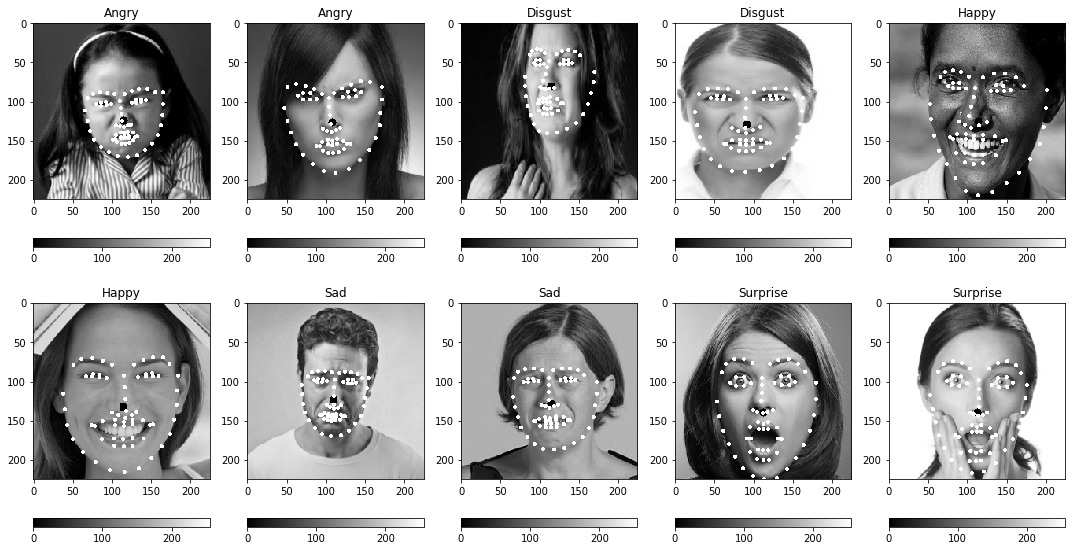

In [5]:
# Tamanho extra para recortar o rosto
N = 60

plt.figure(figsize=(15, 8))
for p, frame in enumerate(frames):
    # grayscale
    gray = cv2.cvtColor(frame[0], cv2.COLOR_RGB2GRAY)
    
    # Shape para calcular algumas questões...
    wg, hg = gray.shape
    
    # Cortar exatamente a posição da face
    for face_cascade in face_cascades:
        faces = face_cascade.detectMultiScale(gray, 1.1, 1, minSize=(15, 15), flags=cv2.CASCADE_SCALE_IMAGE)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            yN, xN = np.abs(y-N), np.abs(x-N)
            yNh, xNw = np.abs((y+N)+h), np.abs((x+N)+w)
            gray = gray[yN:yNh, xN:xNw]
            break
    
    # Resize, para ficarem todas do mesmo tamanho
    gray = cv2.resize(gray, (225, 225))
    
    xlist = []
    ylist = []
    # Adicionar os pontos de identificação da face
    clahe_image = clahe.apply(gray)
    detections = detector(clahe_image, 1) #Detect the faces in the image
    for k,d in enumerate(detections): #For each detected face
        shape = predictor(clahe_image, d) #Get coordinates
        for i in range(1, 68): #There are 68 landmark points on each face
            xlist.append(shape.part(i).x)
            ylist.append(shape.part(i).y)
    xmean = int(np.mean(xlist))
    ymean = int(np.mean(ylist))
    
    # Normalizando o centro de massa, podemos mover todos os pontos para o novo centro de massa,
    # mas isso acarretaria em termos de rotacionar e mover o rosto... o que mudaria novamente o centro de massa.
    # nx, ny = xlist[29], ylist[29] # Ponta do Nariz
    # ax = (math.atan2(nx, xmean) * 180) / math.pi
    # ay = (math.atan2(ny, ymean) * 180) / math.pi
    # xlist = xlist + np.abs(np.linalg.norm(nx-xmean)) * np.cos(ax * np.pi / 180)
    # ylist = ylist + np.abs(np.linalg.norm(ny-ymean)) * np.sin(ay * np.pi / 180)
    
    cv2.circle(gray, (xmean, ymean), 1, (0, 0, 0), thickness=8)
    for x, y in zip(xlist, ylist):
        # For each point, draw a red circle with thickness2 on the original frame
        cv2.circle(gray, (int(x), int(y)), 1, (255, 255, 255), thickness=2)
    
    # Apresentar os resultados
    plt.subplot(2, 5, p + 1)
    plt.title(frame[1])
    plt.imshow(gray, cmap='gray')
    plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

### Rotina para extrair as landmarks (criada no tutorial)

A rotina abaixo **get_landmarks** foi construída pelo autor do tutorial no qual este exercício é baseado.

A idéia é usar o predictor landmarks da *DLib* para encontrar todos os 68 pontos da face.

Inicialmente o autor propõe a normalização das coordenadas dos dados utilizando [Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling), entretanto isto tira muito da variabilidade da distribuição dos pontos em faces diferentes que poderiam acabar ficando correlatas para o classificador.

Partindo desse ponto, o autor propõe o cálculo de um ponto de massa (ou um nó central, equidistante de todos os outros), o qual se calcula realizando a média das distâncias de todos os pontos. Em conjunto com este ponto, é calculado o ângulo de cada ponto em relação a este ponto central.

Isto acaba por gerar um vetor, adicionando alguma variância no modelo.

Por fim, ele explica e apresenta no artigo uma breve explicação sobre o possível ajuste deste ponto de massa caso o mesmo não esteja alinhado com a ponta do nariz.

In [12]:
def get_landmarks(image):
    data = {
        'landmarks_vectorised': []
    }
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        landmarks = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean, xmean))
            coornp = np.asarray((z, w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = []
    return data


def get_only_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        landmarks = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean, xmean))
            coornp = np.asarray((z, w))
            dist = np.linalg.norm(coornp-meannp)
        data = landmarks_vectorised
    if len(detections) < 1:
        data = []
    return data

Apresentação do resultado da função acima para uma de nossas imagens de teste e o **centro de massa** (ponto em preto na imagem).

Landmarks: mostrando os primeiros 15 resultados:
--------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
x,261.000000,263.000000,269.000000,281.000000,299.000000,320.000000,342.000000,373.000000,411.000000,448.000000,481.000000,508.000000,526.000000,536.000000,546.000000
y,183.000000,220.000000,255.000000,291.000000,324.000000,356.000000,387.000000,399.000000,395.000000,376.000000,351.000000,320.000000,283.000000,243.000000,203.000000
dist,132.015655,119.657342,113.852807,113.994300,119.796465,133.855286,155.024405,162.144809,160.669352,154.050143,151.303043,151.313795,151.686535,154.680698,168.057823
ang,-155.819807,-171.796116,170.941467,151.767328,133.480481,117.319351,104.735982,92.981187,79.395712,64.398230,48.847571,33.232363,17.623751,2.195374,-11.698132


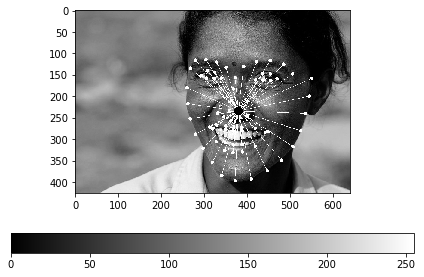

In [14]:
gray = cv2.cvtColor(frames[4][0], cv2.COLOR_RGB2GRAY)
landmarks = get_landmarks(gray)['landmarks_vectorised']
landsmk = np.asarray([landmarks[i:i+4] for i in range(0, len(landmarks), 4)])
print('Landmarks: mostrando os primeiros 15 resultados:')
print('-' * 20)
df = pd.DataFrame(landsmk[:15].T, index=['x', 'y', 'dist', 'ang'])
display(df)

xlist, ylist = [], []
for landmark in landsmk:
    k, l = int(landmark[0]), int(landmark[1])
    dist = landmark[2]
    ang = landmark[3]
    # Usamos os valores da média, para imprimir a posição dos pontos na imagem.
    xlist += [int(381 + dist * np.cos(ang * math.pi / 180))]
    ylist += [int(237 + dist * np.sin(ang * math.pi / 180))]

white = (255, 255, 255)
xmean = int(np.mean(xlist))
ymean = int(np.mean(ylist))
for x, y in zip(xlist, ylist):
    cv2.circle(gray, (x, y), 1, white, thickness=5)
    cv2.line(gray, (x, y), (xmean, ymean), white, thickness=1)
cv2.circle(gray, (xmean, ymean), 1, (0, 0, 0), thickness=18)
plt.imshow(gray, cmap='gray')
plt.colorbar(orientation='horizontal')
plt.tight_layout()

### Carregando o dataset de faces do Cohn-Kanade

Na continuação do tutorial o autor se utiliza do dataset Cohn-Kanade, o qual pode ser feito download, solicitando acesso (vide link no fim do documento).

Após acesso, foi necessário realizar o download de dois arquivos, o primeiro deles contém todas as imagens das faces. Já o segundo, representa os valores das emoções para cada coleção.

No arquivo de emoções (o qual esta todo definido com valores em ponto flutuante), o material descrimina 7 emoções, que são:

 - Anger
 - Contempt
 - Disgust
 - Fear
 - Happy
 - Sadness
 - Surprise
 
No próprio documento, é apresentado que nem todo o dataset foi marcado com emoções, portanto foi necessário fazer um pré-processamento e geração do dataset final, o qual é apresentado abaixo.

Esse pré-processamento, pode ser visualizado acessando o arquivo **cohn-kanade-generator.py**, o qual não é apresetando aqui por motivos de espaço.

Quantidade de Imagens por sentimento: 
--------------------
Neutral :  326
Anger   :  135
Contempt:  54
Disgust :  177
Fear    :  75
Happy   :  207
Sadness :  84
Surprise:  249


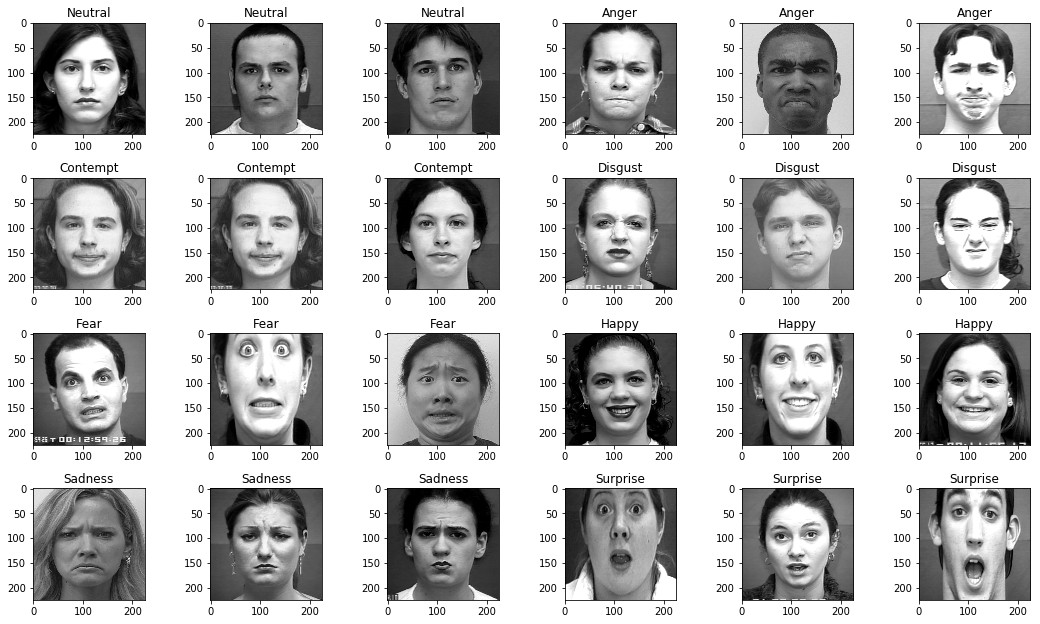

In [15]:
emotions = {sentiment : [] for sentiment in sentiments}

for emotion in emotions.keys():
    for file in glob.glob(f'dataset/*/*/{emotion}*', recursive=True):
        emotions[emotion].append(file)

print('Quantidade de Imagens por sentimento: ')
print('-' * 20)
print('Neutral : ', len(emotions['neutral']))
print('Anger   : ', len(emotions['anger']))
print('Contempt: ', len(emotions['contempt']))
print('Disgust : ', len(emotions['disgust']))
print('Fear    : ', len(emotions['fear']))
print('Happy   : ', len(emotions['happy']))
print('Sadness : ', len(emotions['sadness']))
print('Surprise: ', len(emotions['surprise']))

plt.figure(figsize=(15, 15))
N = 0
for emt in emotions.keys():
    for i in range(N, N + 3):
        ax = plt.subplot(7, 6, i + 1)
        image = cv2.imread(choices(emotions[emt])[0])
        plt.title(emt.title())
        plt.imshow(image, cmap='gray')
    N += 3
plt.tight_layout()
plt.show()

### Carregamento dos dados para Treinamento

O próximo passo é carregar todas as imagens das emoções e prepará-las efetivamente para o treinamento.

In [50]:
def get_files(emotion):
    """Carrega todos os arquivos do disco e separa em base de treinamento e teste."""
    files = []
    for file in glob.glob(f'dataset/*/*/{emotion}*', recursive=True):
        files.append((emotion, file))
    shuffle(files)
    return files[:int(len(files) * 0.8)], files[-int(len(files)*0.2):]

training, prediction = get_files('neutral')
print('Training data size   : ', len(training), 'files')
print('Prediction data size : ', len(prediction), 'files')

Training data size   :  260 files
Prediction data size :  65 files


Vamos realizar a leitura de todas as imagens e coletar os landmarks de cada uma delas, iremos separar todo nosso conjunto de imagens em 2 partes.

Uma parte iremos treinar nosso classificador, e em seguida, com a segunda parte iremos validar nosso classificador, verificando se a predição do mesmo acerta os labels das imagens restantes.

In [58]:
def transform_data(dt):
    _data, _label = None, None
    emotion, image = dt
    image = cv2.imread(image) #open image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
    clahe_image = clahe.apply(gray)
    data = get_landmarks(clahe_image)
    if len(data['landmarks_vectorised']) > 0:
        _data = data['landmarks_vectorised'] #append image array to training data list
        _label = emotion
    return _data, _label

from multiprocessing import Pool

def make_sets():
    pool = Pool(3)
    
    train_data, train_labels, predict_data, predict_labels = [], [], [], []
    for sentiment in sentiments:
        training, prediction = get_files(sentiment)
        results_train = pool.map(transform_data, training)
        for result in results_train:
            t_data, t_labels = result[0], result[1]
            if t_data:
                train_data.append(t_data)
                train_labels.append(t_labels)
        results_predic = pool.map(transform_data, prediction)
        for result in results_predic:
            p_data, p_labels = result[0], result[1]
            if p_data:
                predict_data.append(p_data)
                predict_labels.append(p_labels)
    return np.asarray(train_data, dtype=np.float32), \
            np.asarray(train_labels), \
            np.asarray(predict_data, dtype=np.float32), \
            np.asarray(predict_labels)

td, tl, pd2, pl2 = make_sets()
df = pd.DataFrame(td)
display(df.head(10))

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,35.0,92.0,80.308998,-174.507675,39.0,115.0,77.468895,168.599136,44.0,136.0,...,38.173958,77.811363,115.0,138.0,38.313480,89.910721,108.0,137.0,37.953392,100.536606
1,49.0,105.0,68.066986,-162.399399,52.0,121.0,62.050011,-175.765137,55.0,137.0,...,28.875351,79.787865,113.0,154.0,28.431551,91.774879,106.0,153.0,28.527979,106.035980
2,44.0,122.0,69.578362,-171.537903,46.0,139.0,67.162086,174.222260,49.0,157.0,...,23.585022,74.811661,112.0,156.0,23.775370,91.978653,104.0,155.0,24.410656,111.183388
3,41.0,119.0,68.019638,-171.736542,43.0,136.0,65.711708,173.688553,46.0,154.0,...,28.576145,72.303215,109.0,157.0,28.232229,88.606514,100.0,156.0,28.464941,106.981247
4,48.0,109.0,67.252983,-161.737961,51.0,127.0,60.943279,-177.108170,53.0,144.0,...,26.252954,80.939316,109.0,157.0,27.077440,96.075127,103.0,156.0,27.399363,108.879097
5,36.0,114.0,75.872810,-168.252396,38.0,131.0,72.300247,178.769806,43.0,148.0,...,27.650759,73.795464,111.0,157.0,27.561552,88.510521,103.0,156.0,27.533106,105.339569
6,43.0,109.0,68.583229,-163.331802,45.0,126.0,63.757492,-177.598419,47.0,143.0,...,27.321249,74.506050,109.0,157.0,28.329931,89.396271,102.0,156.0,28.138039,103.778259
7,36.0,112.0,77.209915,-164.711853,40.0,131.0,70.490700,-178.895966,45.0,150.0,...,30.183241,71.609848,112.0,162.0,29.680861,87.059898,103.0,161.0,29.601805,104.631813
8,40.0,114.0,70.205093,-166.049438,42.0,132.0,66.143059,179.069077,44.0,149.0,...,27.508366,79.811935,107.0,159.0,28.097534,92.313721,100.0,158.0,28.270174,106.722420
9,43.0,106.0,71.261398,-160.802261,46.0,124.0,64.527618,-175.170319,48.0,142.0,...,34.047932,80.360123,108.0,165.0,35.641357,93.697563,101.0,163.0,34.831261,105.483368


### Treinamento

Finalmente, vamos utilizar os dados carregados e realizar o treinamento do nosso modelo.

Juntamente, iremos realizar a avaliação do mesmo em 15 épocas.

Training SVM linear, epoch : 0
Training SVM linear, epoch : 1
Training SVM linear, epoch : 2
Training SVM linear, epoch : 3
Training SVM linear, epoch : 4
Training SVM linear, epoch : 5
Training SVM linear, epoch : 6
Training SVM linear, epoch : 7
Training SVM linear, epoch : 8
Training SVM linear, epoch : 9
Mean accuracy: 83.79%
Min accuracy : 80.47%
Max accuracy : 85.99%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,80.47,83.72,81.64,85.49,83.72,85.16,85.99,85.94,82.95,82.81


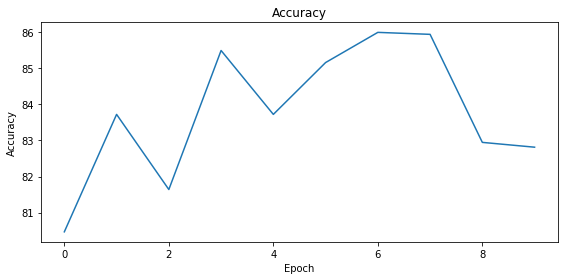

In [56]:
clf = SVC(kernel='linear', probability=True, tol=1e-3)
accur_lin = []
pred_lin = []

epochs = range(10)
for i in epochs:
    train_data, train_labels, predict_data, predict_labels = make_sets()
    print(f'Training SVM linear, epoch : {i}')  # train SVM
    clf.fit(train_data, train_labels)
    pred_lin_v = clf.score(predict_data, predict_labels)
    pred_lin.append(pred_lin_v * 100)
    accur_lin.append(pred_lin_v)  # store accuracy in a list
print(f'Mean accuracy: {np.round(np.mean(accur_lin) * 100, 2)}%')
print(f'Min accuracy : {np.round(np.min(accur_lin) * 100, 2)}%')
print(f'Max accuracy : {np.round(np.max(accur_lin) * 100, 2)}%')
df = pd.DataFrame(np.asarray([np.round(pred_lin, 2)]), index=['accuracy'], columns=[f'epoch : {i}' for i in epochs])
display(df)

plt.figure(figsize=(8, 4))
plt.title('Accuracy')
plt.plot(np.asarray(pred_lin))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

### Validação

Vamos validar nosso modelo com algumas imagens e verificar o quanto ele consegue ser efetivo em determinar as emoções em imagens diferentes das existentes em nosso dataset original do Cohn-Kanade.

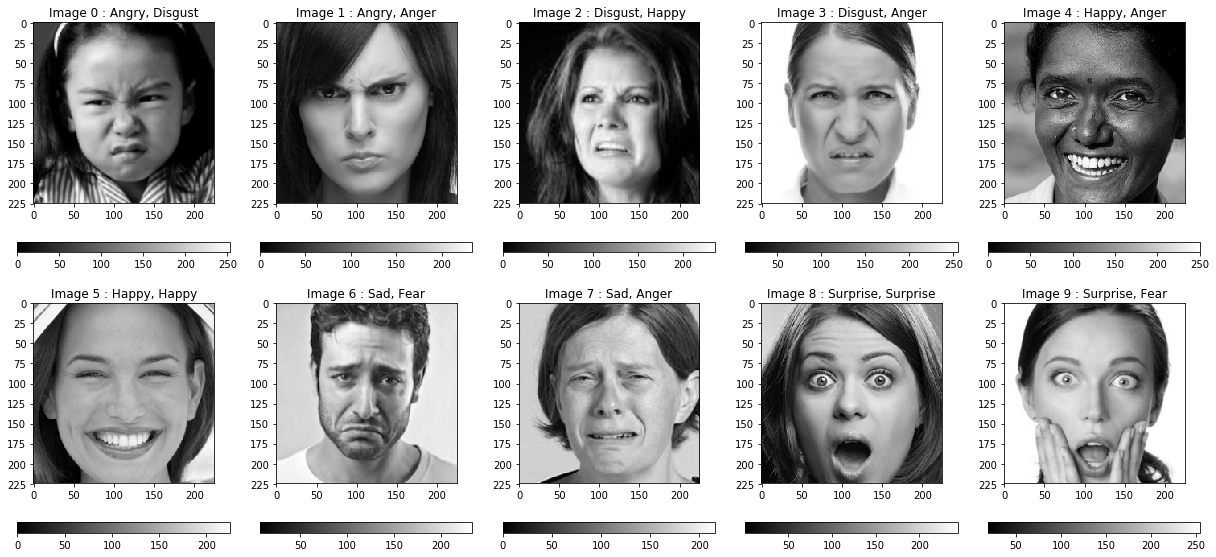

In [59]:
sents_prob = []
images = []

plt.figure(figsize=(17, 8))
for p, frame in enumerate(frames):
    # grayscale
    gray = cv2.cvtColor(frame[0], cv2.COLOR_RGB2GRAY)
    
    # Shape para calcular algumas questões...
    wg, hg = gray.shape
    
    # Cortar exatamente a posição da face
    for face_cascade in face_cascades:
        faces = face_cascade.detectMultiScale(gray, 1.1, 1, minSize=(15, 15), flags=cv2.CASCADE_SCALE_IMAGE)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            yN, xN = np.abs(y-N), np.abs(x-N)
            yNh, xNw = np.abs((y+N)+h), np.abs((x+N)+w)
            gray = gray[yN:yNh, xN:xNw]
            break
    
    # Resize, para ficarem todas do mesmo tamanho
    gray = cv2.resize(gray, (225, 225))
    clahe_image = clahe.apply(gray)
    data = get_landmarks(clahe_image)
    sentiment = clf.predict([data['landmarks_vectorised']])[0]
    probs = clf.predict_proba([data['landmarks_vectorised']])
    
    snt = []
    for k, prob in enumerate(probs[0]):
        snt.append(np.round(prob * 100, 1))
    sents_prob.append(snt)
    images.append(f'Image {p}')
    
    # Apresentar os resultados
    plt.subplot(2, 5, p + 1)
    plt.title(f'Image {p} : {frame[1]}, {sentiment.title()}')
    plt.imshow(gray, cmap='gray')
    plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

In [60]:
df = pd.DataFrame(sents_prob, columns=sentiments, index=images)
display(df)

,neutral,anger,contempt,disgust,fear,happy,sadness,surprise
Image 0,3.0,1.3,69.1,0.9,0.6,13.5,3.0,8.6
Image 1,55.1,6.0,8.5,1.3,2.4,18.3,3.6,4.7
Image 2,5.0,8.3,20.1,19.7,29.3,4.3,4.9,8.3
Image 3,39.4,3.8,37.5,2.8,3.7,5.9,3.5,3.2
Image 4,38.0,9.5,8.4,17.5,11.5,5.0,2.1,8.1
Image 5,1.1,18.7,2.3,2.7,68.0,2.0,0.8,4.4
Image 6,5.7,2.9,4.6,21.4,17.6,8.3,22.4,16.9
Image 7,62.2,13.0,1.9,8.1,2.0,6.0,2.1,4.7
Image 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
Image 9,0.8,0.7,0.1,80.5,0.1,2.2,0.8,14.8


### Considerações Finais

Conforme descrito pelo autor do artigo, apesar de uma tarefa extremamente complexa (a de reconhecer emoções através dos landmarks faciais), os algoritmos de Machine Learning (especialmente o SVC), conseguem predizer uma probabilidade de entre 80-90% o sentimento apresentado. Mas isso em um dataset mais controlado, quando adicionamos imagens diferentes, como esse teste com nossas 10 imagens, o algoritmo pode se enganar em alguns casos.

Interessante notar também, que o autor do artigo, ainda traça um paralelo com o uso computacional executado pelo computador para a tarefa de reconhecimento de emoções, e o exercido pelo nosso cérebro. Realmente, nosso cérebro consegue realizar tarefas de reconhecimento e associações bem mais rápido e com menor informações (partes de uma imagem por exemplo) que o computador conseguiria.

Assim, como o autor apresenta, um próximo passo na tentativa de melhorar (ou de exploração) seria a implementação dos passos apresentados acima, mas utilizando-se de Redes Neurais.

Ou até mesmo outras alternativas, como a discutida em sala de aula, na qual foi utilizado o método geométrico (apresentado acima) e de textura (LBP). Com toda a certeza, usando esse método híbrido (geometria + textura) teremos mais features a serem analisadas pelos algoritmos, e dependendo da variância, poderia melhorar a acurácia.

### Citação

[Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV](http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/)

- van Gent, P. (2016). Emotion Recognition Using Facial Landmarks, Python, DLib and OpenCV. A tech blog about fun things with Python and embedded electronics

[Emotion Recognition With Python, OpenCV and a Face Dataset](http://www.paulvangent.com/2016/04/01/emotion-recognition-with-python-opencv-and-a-face-dataset/)

- van Gent, P. (2016). Emotion Recognition With Python, OpenCV and a Face Dataset. A tech blog about fun things with Python and embedded electronics

[Cohn-Kanade (CK and CK+) database Download Site](http://www.consortium.ri.cmu.edu/ckagree/)

- Kanade, T., Cohn, J. F., & Tian, Y. (2000). Comprehensive database for facial expression analysis. Proceedings of the Fourth IEEE International Conference on Automatic Face and Gesture Recognition (FG'00), Grenoble, France, 46-53.
- Lucey, P., Cohn, J. F., Kanade, T., Saragih, J., Ambadar, Z., & Matthews, I. (2010).